In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 16)

FILENAME = 'images/annotated_raw/9.jpg'
FNAME_ANNOTATED = 'images/annotated_colors/9-colored.png'
# OFILE = ODIR + FNAME

**Read grayscale image**

TypeError: Image data of dtype object cannot be converted to float

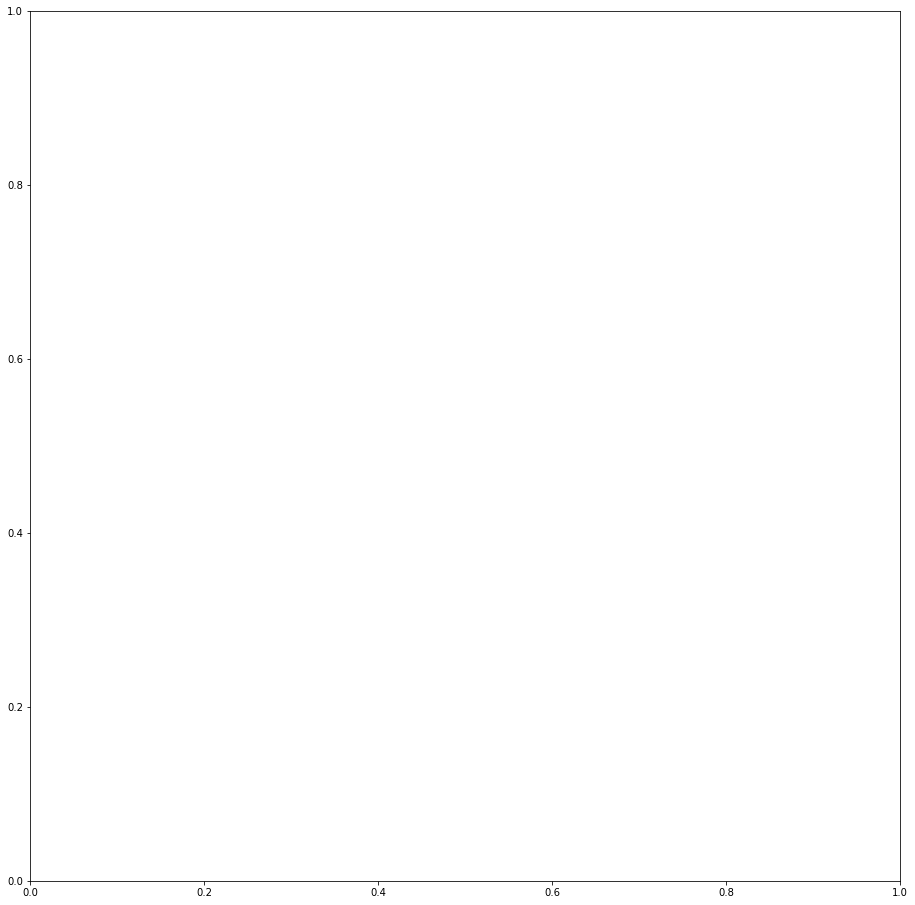

In [2]:
## Read grayscale image, 
img = cv2.imread(FILENAME, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap = 'gray')
plt.show()

**Filter To Drop Shadows, Pre-Process Bone Isolation**

* May want to use additional histogram based approaches here!

In [ ]:
# Truncate all image values below threshold
ret,truncd = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)

# Take 5x5 pixel normalized average across image
blur = cv2.GaussianBlur(truncd,(5,5),0)

# Apply binary threshold, Otsu threshold
ret3,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Filter morphology - close gaps
kernel = np.ones((7,7),np.uint8)
closing = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)

**Use Recursive convex hull to identify bone in image**

In [ ]:
## Contour to find bone region
ret4 = closing.copy()
contours, hierarchy = cv2.findContours(ret4,                                       
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_TC89_L1)


                                       
areas = [cv2.contourArea(c) for c in contours]
max_index = np.argmax(areas)
print(max_index)

color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
tmp2 = color_img.copy() ## Save a copy, `drawContours` will mess with the image

out = cv2.drawContours(color_img, contours, max_index, (0,255,0), 3)
plt.imshow(out)
plt.show()

**Isolate bone**

In [ ]:
bone = contours[max_index]

fill_color = [0,0,0]
mask_value = 255

stencil = np.zeros(tmp2.shape[:-1]).astype(np.uint8)
cv2.fillPoly(stencil, [bone], mask_value)

sel = (stencil != mask_value)
tmp2[sel] = fill_color

BASE_IMG = cv2.cvtColor(tmp2, cv2.COLOR_BGR2GRAY)
plt.imshow(BASE_IMG, cmap = 'gray')
plt.show()

In [ ]:
#cv2.imwrite(OFILE, BASE_IMG)

**Apply Color Quantization**

We will use 4 colors to represent five categories of mineralized bone or lack thereof we may find in an image.  

We must assume that these five categories will exist in any 

1. Pitch Black `0` - no bone in this pixel

...

8. ?

We proceed to take the array of grayscale values in the image, and categorize all pixels of the image using $k$-means clustering.  This is done using 10-fold cross-validation and initially random pixels representing grayscale values for each of the NN categories (centers).

In [ ]:
img = BASE_IMG.copy()
Z = img.reshape((-1,2))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            4096, 1E-5)
K = 10
ret,label,center=cv2.kmeans(Z,K,None,criteria,20,
                            cv2.KMEANS_RANDOM_CENTERS)

# New Stuff A

Now let's take the clusters identified and reform it into an image with consistent grayscale values.  In the printout below this cell, you can observe a listing of the lower and upper estimates for the grayscale value associated with a cluster, followed by an image colored in with the adjusted (consistent) values. 

In [ ]:
# These are the estimates for the centroids; 
# the estimate for the grayscale value for that cluster
print(np.uint16(center))

# We want to floor & reassign the midpoints of the estimates
# to be the centroids proper.  This avoids rounding issues
# when using the lower/upper estimates
for i in range(0,len(center)):
    a = center[i]
    b = (a[0] + a[1]) / 2
    center[i] = np.array([b, b])

# Now convert back into uint8, and make original image
# This is done for demonstration/viz purposes, we will not 
# be able to directly use these values
center_conv = np.uint8(center)
res = center_conv[label.flatten()]
res2 = res.reshape((img.shape))

plt.imshow(res2, cmap = 'gray')
plt.show()

# Lamellar Area Comparison

## Proportion Estimation (Lamellar / Non)

**However, what makes more sense now, is that we know clusters near the "middle" of the histogram have an "average" mineralization content -- and therefore may be lamellar.  This means that given 7 clusters, minus the "black"/"empty" bucket (for a total of 6 clusters), the middle buckets may be lamellar and the futher from the mean, the outer buckets are probably non-lamellar**

Here are the grayscale values sorted, in order. 

In [ ]:
tmp1 = res2.copy()
category_grayscale_values = np.sort(np.unique(tmp1.flatten()))
category_grayscale_values

Here, instead, I keep everything in the middle buckets. 

In [ ]:
tmp1 = res2.copy()

tmp1[np.where(tmp1 == category_grayscale_values[0])] = [0]
tmp1[np.where(tmp1 == category_grayscale_values[1])] = [0]
tmp1[np.where(tmp1 == category_grayscale_values[2])] = [0]
tmp1[np.where(tmp1 == category_grayscale_values[3])] = [0]
tmp1[np.where(tmp1 == category_grayscale_values[4])] = [0]
tmp1[np.where(tmp1 == category_grayscale_values[5])] = [0]
#tmp1[np.where(tmp1 == category_grayscale_values[6])] = [0]
#tmp1[np.where(tmp1 == category_grayscale_values[7])] = [0]
#tmp1[np.where(tmp1 == category_grayscale_values[8])] = [0]
tmp1[np.where(tmp1 == category_grayscale_values[9])] = [0]


plt.imshow(tmp1, cmap = 'gray')
plt.show()

Now, we want to get the proportional area out of the original identified bone (the convex hull/contour step with green outline).  

In [ ]:
#area_identified_bone = areas[np.argmax(areas)]
#print(area_identified_bone)

area_identified_bone = cv2.countNonZero(res2)
area_identified_bone

In [ ]:
area_lamellar_est = cv2.countNonZero(tmp1)
area_lamellar_est

In [ ]:
proportion_est = area_lamellar_est / area_identified_bone
proportion_est

## Annotation Proportion

Now let's compare to the annotation;

In [ ]:
## Read annotated red/blue image, 
annotated_img = cv2.imread(FNAME_ANNOTATED)
annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2HSV)

color_dict_HSV = {'black': [[180, 255, 30], [0, 0, 0]],
              'white': [[180, 18, 255], [0, 0, 231]],
              'red1': [[180, 255, 255], [159, 50, 70]],
              'red2': [[9, 255, 255], [0, 50, 70]],
              'green': [[89, 255, 255], [36, 50, 70]],
              'blue': [[128, 255, 255], [90, 50, 70]],
              'yellow': [[35, 255, 255], [25, 50, 70]],
              'purple': [[158, 255, 255], [129, 50, 70]],
              'orange': [[24, 255, 255], [10, 50, 70]],
              'gray': [[180, 18, 230], [0, 0, 40]]}

plt.imshow(annotated_img)
plt.show()

### Get the Red (Non-Lamellar) Area

In [ ]:
## Identify BLUE (lamellar) using HSV colorspace
img_hsv = annotated_img.copy()

# lower mask (0-10)
lower_red = np.array([0,50,50])
upper_red = np.array([10,255,255])
mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

# upper mask (170-180)
lower_red = np.array([170,50,50])
upper_red = np.array([180,255,255])
mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

# join masks for lower and upper bound of red values
mask = mask0+mask1

# Set everything else to zero
output_hsv = img_hsv.copy()
output_hsv[np.where(mask==0)] = 0

r = cv2.cvtColor(output_hsv, cv2.COLOR_HSV2RGB)
r = cv2.cvtColor(output_hsv, cv2.COLOR_RGB2GRAY)
red_area = cv2.countNonZero(r)
print(red_area)

plt.imshow(r, cmap='gray')
plt.show()

### Get the Blue (Lamellar) Area

In [ ]:
## Identify RED (non-lamellar) using HSV colorspace
img_hsv = annotated_img.copy()

# lower mask (0-10)
lower_blue = np.array(color_dict_HSV['blue'][1])
upper_blue = np.array(color_dict_HSV['blue'][0])
mask = cv2.inRange(img_hsv, lower_blue, upper_blue)

# Set everything else to zero
output_hsv = img_hsv.copy()
output_hsv[np.where(mask==0)] = 0

b = cv2.cvtColor(output_hsv, cv2.COLOR_HSV2RGB)
b = cv2.cvtColor(output_hsv, cv2.COLOR_RGB2GRAY)
blue_area = cv2.countNonZero(b)
print(blue_area)

plt.imshow(b, cmap='gray')
plt.show()

### What's the Annotated Proportion?

In [ ]:
annotated_prop = blue_area / (blue_area + red_area)
annotated_prop

# What's the difference in proportion? 

In [ ]:
proportion_est - annotated_prop